# <p style="text-align: center;">Quick Air Quality Model</p>
#### <p style="text-align: center;">Edmund Walsh -- Aug. 27th, 2020</p>

The structure of this analysis will be to:
1. Load and clean the data
2. Answer a few questions about the data
3. Build A Simple Linear Model
4. Build a Benchmark Model and Compare

### Data
The data for this analysis comes from the UCI Machine Learning Repository and can be found here: https://archive.ics.uci.edu/ml/datasets/Air+quality. The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. 

In [1]:
# download data
import wget
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
filename = wget.download(url)

100% [..........................................................................] 1543989 / 1543989

After downloading, unzip the file in the directory

In [1]:
import numpy as np
import pandas as pd
import statistics
import datetime
import math

In [16]:
## load data and a quick lookover
airqual = pd.read_csv('./AirQualityUCI/AirQualityUCI.csv', sep=";", thousands=",", parse_dates=["Date","Time"])
airqual.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-10-03,18.00.00,26.0,1360.0,150.0,119.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,136.0,489.0,7578.0,NaN,NaN
1,2004-10-03,19.00.00,2.0,1292.0,112.0,94.0,955.0,103.0,1174.0,92.0,1559.0,972.0,133.0,477.0,7255.0,NaN,NaN
2,2004-10-03,20.00.00,22.0,1402.0,88.0,90.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,119.0,540.0,7502.0,NaN,NaN
3,2004-10-03,21.00.00,22.0,1376.0,80.0,92.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,110.0,600.0,7867.0,NaN,NaN
4,2004-10-03,22.00.00,16.0,1272.0,51.0,65.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,112.0,596.0,7888.0,NaN,NaN


Looking at the description of the data below, we can see some suspect values. In the data section above, it does state that missing values are represented as -200 but there are also values of -2000 which, for this analysis, we will assume are also missing.

In [17]:
airqual.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,-36.996687,1048.990061,-159.090093,18.656834,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,168.190232,465.260981,9846.342524,NaN,NaN
std,211.793927,329.832710,139.789093,413.802064,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,114.081191,216.407635,4447.196714,NaN,NaN
min,-2000.000000,-200.000000,-200.000000,-2000.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,4.000000,921.000000,-200.000000,40.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,109.000000,341.000000,6923.000000,NaN,NaN
50%,14.000000,1053.000000,-200.000000,79.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,172.000000,486.000000,9768.000000,NaN,NaN
75%,25.000000,1221.000000,-200.000000,136.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,241.000000,619.000000,12962.000000,NaN,NaN
max,119.000000,2040.000000,1189.000000,637.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,446.000000,887.000000,22310.000000,NaN,NaN


Preprocessing is an important part of data science. However, given that this is a quick overview. I am normally hesitant to apply this kind of technique to the data as it can be easy to drop out insights. This is a preference, but in short, I prefer to have solid justification for any change to the data. Therefore, we will take a more direct approach for filling in these missing values.

### Data Insights
The next section of the test looks for a few data points within our air quality data set.
1. What what the average CO level during the month of May in 2004
2. What is the most common day and time for the highest CO
3. Which month had the lowest average humidity
4. What are the correlations of the different variables to CO

In [18]:
%%capture
may_df = airqual[airqual['Date'] > '2004-04-30']
may_df = may_df[airqual['Date'] < '2004-06-1']
may_co_mean = statistics.mean(may_df['CO(GT)'])

In [19]:
"The Average CO Level During May 2004 was {:.2f}".format(may_co_mean)

'The Average CO Level During May 2004 was -31.67'

In [20]:
top_co = airqual.sort_values(["CO(GT)"], ascending=False).iloc[:10,]
avg_toptime = statistics.mean(list(map(lambda x: int(x[:2]),top_co['Time'])))
avg_day = statistics.mean(list(map(lambda x: x.weekday(), list(top_co['Date']))))
"The highest CO levels are at the going into Wednesday, about halfway between Tuesday and Wednesday, at just after 6:30pm"

'The highest CO levels are at the going into Wednesday, about halfway between Tuesday and Wednesday, at just after 6:30pm'

In [21]:
mth = list(map(lambda x: x.month, list(airqual['Date'])))
airqual['Month'] = mth
ah_df = airqual[["AH","Month"]].dropna()

In [22]:
mean_avg_ah = ah_df.groupby('Month').mean()
mean_avg_ah[mean_avg_ah["AH"] == min(mean_avg_ah["AH"])]
"The lowest humidity is in December"

'The lowest humidity is in December'

In [11]:
# Here we show the rank correlatino with CO of the other variables, before the cleaning step
df_corr = airqual.corr()
df_co_corr = df_corr['CO(GT)'][1:]
df_co_corr.sort_values(ascending=False)

NO2(GT)          0.278905
NOx(GT)          0.264291
PT08.S5(O3)      0.117769
PT08.S2(NMHC)    0.109069
NMHC(GT)         0.082723
Month            0.075663
PT08.S1(CO)      0.072755
PT08.S4(NO2)     0.070430
T                0.022497
AH               0.002620
C6H6(GT)        -0.007046
RH              -0.053690
PT08.S3(NOx)    -0.132442
Unnamed: 15           NaN
Unnamed: 16           NaN
Name: CO(GT), dtype: float64

### Cleaning the data
In this section, we will:
1. Clean these missing values
2. Add a target variable which is a 1 hour lag for our model prediction

In [72]:
airqual = pd.read_csv('./AirQualityUCI/AirQualityUCI.csv', sep=";", thousands=",", parse_dates=["Date","Time"])
airqual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
 15  Unnamed: 15    0 non-

In [73]:
# lets remove the nulls # first the columns
airqual = airqual.iloc[:,:15]
# then the rows
airqual = airqual.dropna()
airqual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [74]:
# now, we should replace the missing values that are represented as -200 or -2000
airqual.replace(to_replace=-200,value=None,inplace=True)
airqual.replace(to_replace=-2000,value=None,inplace=True)
# I find it most likely that these are sensor failures, so I will backfill this data to the most recent measurement
airqual.fillna(method='bfill',inplace=True)
airqual.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.00000,9357.000000,9357.000000
mean,19.509031,1102.730362,270.496740,101.903922,942.548253,240.731217,832.742225,109.414877,1453.014535,1030.511916,183.17356,488.174308,10173.815539
std,15.016972,219.588101,73.306853,75.657712,269.581368,206.618453,255.709423,47.221662,347.434084,410.916759,88.21883,173.543259,4048.288597
min,1.000000,647.000000,7.000000,1.000000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-19.00000,92.000000,1847.000000
25%,8.000000,938.000000,275.000000,44.000000,733.000000,97.000000,655.000000,73.000000,1228.000000,726.000000,119.00000,354.000000,7262.000000
50%,16.000000,1062.000000,275.000000,83.000000,911.000000,174.000000,807.000000,102.000000,1460.000000,964.000000,176.00000,489.000000,9875.000000
75%,26.000000,1237.000000,275.000000,140.000000,1117.000000,318.000000,968.000000,137.000000,1677.000000,1287.000000,243.00000,619.000000,13067.000000
max,119.000000,2040.000000,1189.000000,637.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,446.00000,887.000000,22310.000000


Above, we can see a marked improvement in the quality of the data. As such, let's move on to building our model

### Building A Simple Model
In this section, we will lag the CO variable by one hour as instructed to the test, we will benchmark this model vs. a simple AR1 model

In [75]:
airqual['target'] = airqual['CO(GT)'].shift(-1)
# since we have shifted the data, we have introduced another na at the end of dataset, we need to again remove
airqual = airqual.dropna()
airqual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9356 entries, 0 to 9355
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9356 non-null   datetime64[ns]
 1   Time           9356 non-null   object        
 2   CO(GT)         9356 non-null   float64       
 3   PT08.S1(CO)    9356 non-null   float64       
 4   NMHC(GT)       9356 non-null   float64       
 5   C6H6(GT)       9356 non-null   float64       
 6   PT08.S2(NMHC)  9356 non-null   float64       
 7   NOx(GT)        9356 non-null   float64       
 8   PT08.S3(NOx)   9356 non-null   float64       
 9   NO2(GT)        9356 non-null   float64       
 10  PT08.S4(NO2)   9356 non-null   float64       
 11  PT08.S5(O3)    9356 non-null   float64       
 12  T              9356 non-null   float64       
 13  RH             9356 non-null   float64       
 14  AH             9356 non-null   float64       
 15  target         9356 n

In [76]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [77]:
df_corr = airqual.corr()
df_co_corr = df_corr['CO(GT)'][1:]
df_co_corr.sort_values(ascending=False)

target           0.752690
NOx(GT)          0.736721
C6H6(GT)         0.710729
PT08.S1(CO)      0.707961
PT08.S2(NMHC)    0.701620
PT08.S5(O3)      0.685476
NO2(GT)          0.659651
PT08.S4(NO2)     0.452442
NMHC(GT)         0.214824
RH               0.046115
AH               0.003446
T               -0.022841
PT08.S3(NOx)    -0.580250
Name: CO(GT), dtype: float64

Notice, after the data cleaning, the correlation of the different factors and CO had changed substantially.

In [89]:
airqual.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,target
0,2004-10-03,18.00.00,26.0,1360.0,150.0,119.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,136.0,489.0,7578.0,2.0
1,2004-10-03,19.00.00,2.0,1292.0,112.0,94.0,955.0,103.0,1174.0,92.0,1559.0,972.0,133.0,477.0,7255.0,22.0
2,2004-10-03,20.00.00,22.0,1402.0,88.0,90.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,119.0,540.0,7502.0,22.0
3,2004-10-03,21.00.00,22.0,1376.0,80.0,92.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,110.0,600.0,7867.0,16.0
4,2004-10-03,22.00.00,16.0,1272.0,51.0,65.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,112.0,596.0,7888.0,12.0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(airqual.iloc[:,2:(airqual.shape[1]-1)],
                                                    airqual['target'], test_size=0.4, random_state=0)

In [91]:
pdata = y_test
lm = linear_model.LinearRegression()
mod = lm.fit(X_train, y_train)
preds = mod.predict(X_test)
{
    'Mean-abs-error': metrics.mean_absolute_error(y_test, preds),
    'RMSE': math.sqrt(metrics.mean_squared_error(y_test, preds)),
    'R2': metrics.r2_score(y_test, preds)
}

{'Mean-abs-error': 6.181959808818174,
 'RMSE': 9.480745098076717,
 'R2': 0.5973889744022538}

Above, we can see some summary statistics about our model, below we will compare to a simple AR1 model for benchmarking

In [94]:
# create the benchmark AR1
ardata = airqual.loc[:,['CO(GT)','target']]
ardata['icept'] = [1 for i in range(len(airqual))]
ardata.head()

,CO(GT),target,icept
0,26.0,2.0,1
1,2.0,22.0,1
2,22.0,22.0,1
3,22.0,16.0,1
4,16.0,12.0,1


In [95]:
X_train, X_test, y_train, y_test = train_test_split(ardata[['icept','CO(GT)']],ardata['target'], test_size=0.4, random_state=0)
ar = linear_model.LinearRegression(fit_intercept=False)
ar_mod = ar.fit(X_train, y_train)
ar_preds = ar_mod.predict(X_test)
{
    'Mean-abs-error': metrics.mean_absolute_error(y_test, ar_preds),
    'RMSE': math.sqrt(metrics.mean_squared_error(y_test, ar_preds)),
    'R2': metrics.r2_score(y_test, ar_preds)
}

{'Mean-abs-error': 6.426426508349846,
 'RMSE': 10.001454246524329,
 'R2': 0.5519494356408743}

In [97]:
import matplotlib.pyplot as plt

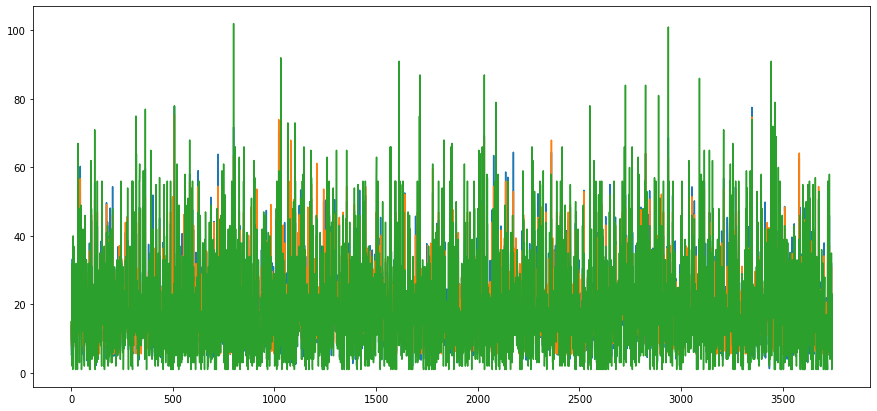

In [101]:
plt.figure(figsize=[15,7])
p1 = plt.plot(preds, label='full model')
p2 = plt.plot(ar_preds, label='AR1 model')
p3 = plt.plot(np.array(y_test), label='actual')

Above, we try to compare the predictions to the actual but it is too noisy to be useful.

Instead, it can be useful to compare cumulative sum of the errors between the two models which we do below.

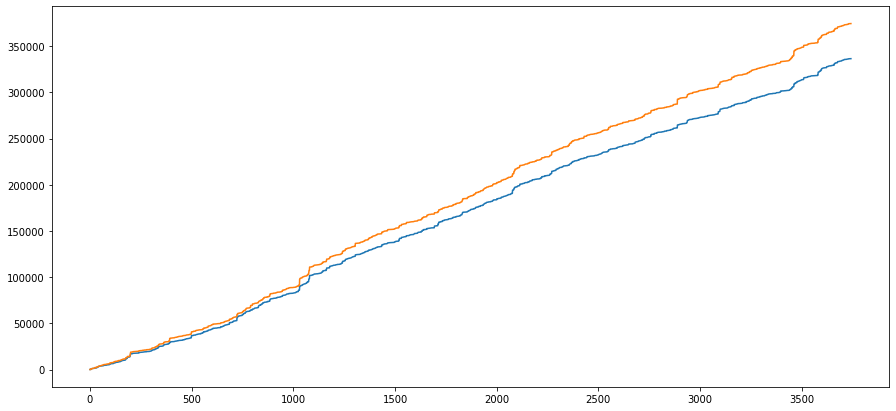

In [103]:
plt.figure(figsize=[15,7])
plt.plot(np.array(pd.Series((y_test-preds)**2).cumsum()),label="full model")
plt.plot(np.array(pd.Series((y_test-ar_preds)**2).cumsum()),label="AR1 model")

We can see that our full model outperforms the simple AR1 relatively consistently which leads to a significant improvement over time.

#### Conclusion
From here, we should begin more in-depth feature engineering, get to know our data better, and then think about what models make the most sense to apply and why. We have set a good foundation here, but the real work has ust b